# Telecom Customer Churn

For this module examination, I would use data from Kaggle regarding Customer Churn Rate.

Customer attrition, also known as customer churn, customer turnover, or customer defection, is the loss of clients or customers.

The data set includes information about:

- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

<b> Coloumns Descriptions  </b>
- customerID = Customer ID
- gender = Whether the customer is a male or a female
- SeniorCitizen = Whether the customer is a senior citizen or not (1, 0)
- Partner = Whether the customer has a partner or not (Yes, No)
- Dependents = Whether the customer has dependents or not (Yes, No)
- tenure = Number of months the customer has stayed with the company
- PhoneService = Whether the customer has a phone service or not (Yes, No)
- MultipleLines = Whether the customer has multiple lines or not (Yes, No, No phone service)
- InternetService = Customer’s internet service provider (DSL, Fiber optic, No)
- OnlineSecurity = Whether the customer has online security or not (Yes, No, No internet service)
- OnlineBackup = Whether the customer has online backup or not (Yes, No, No internet service)
- DeviceProtection = Whether the customer has device protection or not (Yes, No, No internet service)
- TechSupport = Whether the customer has tech support or not (Yes, No, No internet service)
- StreamingTV = Whether the customer has streaming TV or not (Yes, No, No internet service)
- StreamingMovies = Whether the customer has streaming movies or not (Yes, No, No internet service)
- Contract = The contract term of the customer (Month-to-month, One year, Two year)
- PaperlessBilling = Whether the customer has paperless billing or not (Yes, No)
- PaymentMethod = The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- MonthlyCharges = The amount charged to the customer monthly
- TotalCharges = The total amount charged to the customer
- Churn = Whether the customer churned or not (Yes or No)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Functions 

In [2]:
import scipy.stats as ss
from scipy.stats import chi2_contingency, shapiro, anderson, skew, kurtosis

In [3]:
def correlation_ratio(categories, measurements):
    fcat, _=pd.factorize(categories)
    cat_num=np.max(fcat)+1
    y_avg_array=np.zeros(cat_num)
    n_array=np.zeros(cat_num)
    for i in range(cat_num):
        cat_measures=measurements[np.argwhere(fcat==i).flatten()]
        n_array[i]=len(cat_measures)
        y_avg_array[i]=np.average(cat_measures)
    y_total_avg=np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator=np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator=np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator==0:
        eta=0.0
    else:
        eta=np.sqrt(numerator/denominator)
    return eta

def cramers_v(x,y):
    confusion_matrix=pd.crosstab(x,y)
    chi2=ss.chi2_contingency(confusion_matrix)[0]
    n=confusion_matrix.sum().sum()
    phi2=chi2/n
    r,k=confusion_matrix.shape
    phi2corr=max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr=r-((r-1)**2)/(n-1)
    kcorr=k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
def nullity(data):
    df=pd.DataFrame(columns=['dataFeatures','dataType','null','nullPct','unique','uniqueSample'])
    df['dataFeatures']=data.columns
    df['dataType']=[i for i in data.dtypes]
    df['null']=df['dataFeatures'].apply(lambda x: sum(data[x].isna()))
    df['nullPct']=df['null'].apply(lambda x: round((x/len(data))*100,2))
    df['unique']=df['dataFeatures'].apply(lambda x: len(data[~(data[x].isna())][x].unique()))
    df['uniqueSample']=df['dataFeatures'].apply(lambda x: data[x].drop_duplicates().sample(2).values)
    return df

def make_bootstrap(boot,data,req):
    ci=0.95
    last=[]
    n=len(data)
    for i in range(boot):
        sampling=data.sample(n, replace=True)
        last.append(sampling.mean())
    isi=np.sort(np.array(last))
    level=((1-ci)/2)
    atas=1-level
    batas=[isi[round(level*boot)], isi[round(atas*boot)]]
    if req=='isi':
        return last
    else:
        return batas
    
def try_normal(data):
    result = {'Anderson':{i:j for i,j in zip(anderson(data)[2], anderson(data)[1])},
              'Shapiro':shapiro(data)[1],
              'K^2':normaltest(data)[1]}
    result['Anderson']['stat']=anderson(data)[0]
    return result
    


In [4]:
df = pd.read_csv('Churn_ujian.csv')

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [7]:
df.describe(exclude='object')

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
df.describe(include='object').T

,count,unique,top,freq
customerID,7043,7043,2479-BRAMR,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


In [9]:
nullity(df)

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,customerID,object,0,0.0,7043,"[6147-CBCRA, 3508-VLHCZ]"
1,gender,object,0,0.0,2,"[Female, Male]"
2,SeniorCitizen,int64,0,0.0,2,"[1, 0]"
3,Partner,object,0,0.0,2,"[No, Yes]"
4,Dependents,object,0,0.0,2,"[Yes, No]"
5,tenure,int64,0,0.0,73,"[47, 67]"
6,PhoneService,object,0,0.0,2,"[No, Yes]"
7,MultipleLines,object,0,0.0,3,"[Yes, No phone service]"
8,InternetService,object,0,0.0,3,"[No, Fiber optic]"
9,OnlineSecurity,object,0,0.0,3,"[No, Yes]"


We have no missing value, but as we can see the column TotalCharges have an object data type but when we sampled it they had some numerical value. Let's try to convert this column data type to float

It seems there is some string data that could not be converted to float, Let's try to find the row that is problematic

In [10]:
df[df['TotalCharges']==' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


There are 11 datas with string space character at the TotalCharges Column

In [11]:
print(df[df['TotalCharges']==' '].Churn.unique())
print(df[df['TotalCharges']==' '].tenure.unique())

['No']
[0]


Kolom TotalCharges berhubungan dengan kolom tenure dan churn. Kita tahu bahwa kolom tenure berinformasikan tentang berapa lama customer telah berlangganan dan kolom churn berisikan tentang apakah customer telah membatalkan langganannya bulan lalu. Dapat kita lihat data-data yang memiliki kolom TotalCharges yang berisikan empty string memiliki kolom tenure yang nilainya 0, artinya customer-customer ini baru berlangganan dan belum memmiliki tagihan, sehingga tagihannya kosong. Kolom Churn juga berisikan string 'No' karena customer-customer tersebut merupakan pelanggan baru. 

Try to replace this string value with 0 and convert the Total Charges to the float data type now

In [12]:
df.loc[df['TotalCharges']==' ', 'TotalCharges']=0

Check once more the data row that was previously have string value to make sure the data have been replaced by 0

In [13]:
df['TotalCharges']=df['TotalCharges'].astype('float')
df[df['TotalCharges']==0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,No


In [14]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


I find it interesting that some people still pay their bill via mailed check, lets try to filter the dataset to only get the data with Mailed check class from the PaymentMethod feature

In [15]:
df[df['PaymentMethod']=='Mailed check']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
10,9763-GRSKD,Male,0,Yes,Yes,13,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,49.95,587.45,No
16,8191-XWSZG,Female,0,No,No,52,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,1022.95,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7019,9710-NJERN,Female,0,No,No,39,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.15,826.00,No
7027,0550-DCXLH,Male,0,No,No,13,Yes,No,DSL,No,...,No,Yes,Yes,Yes,Month-to-month,No,Mailed check,73.35,931.55,No
7030,0871-OPBXW,Female,0,No,No,2,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,39.25,No
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No


I am kinda curious, is there any difference between people who have partner or not for people who choose mailed check. Let's try to visualize this by using the countplot. I would also like to create a grid with the Payment Method as the columns to see the difference between each payment method.

Text(0.5, 1.0, 'Mailed Check Payment Method grouped by Partner')

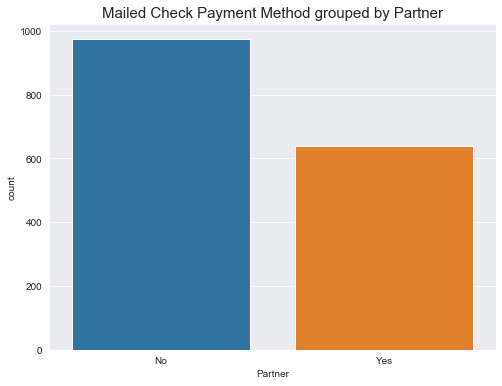

In [16]:
plt.figure(figsize=(8,6))
sns.set_style('darkgrid')
sns.countplot(df[df['PaymentMethod']=='Mailed check']['Partner'])
plt.title('Mailed Check Payment Method grouped by Partner', fontsize=15)

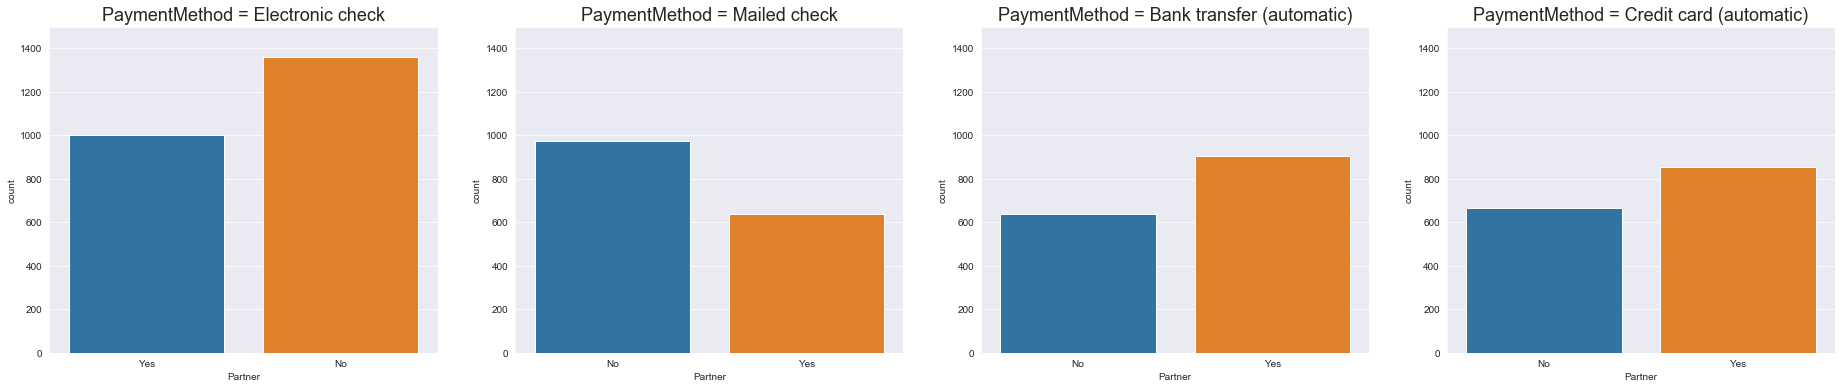

In [17]:
plt.figure(figsize=(32,6))
for num,metode in enumerate(df['PaymentMethod'].unique()):
    plt.subplot(1,len(df['PaymentMethod'].unique()),num+1)
    sns.countplot(df[df['PaymentMethod']==metode]['Partner'])
    plt.ylim(0,1500)
    plt.title('PaymentMethod = {}'.format(metode), fontsize=18)

Seems there is interesting finding that people who paid via Mailed Check are less likely to have partner compared to the other payment method. Let's try to use another feature to find any interesting finding, this time I would use the tenure feature with distribution plot. Just like before, I would create grid with different payment method as the columns.

Text(0.5, 1.0, 'Tenure distribution with Mailed Check Payment Method')

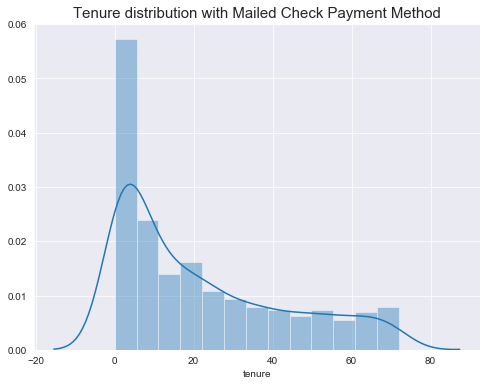

In [18]:
plt.figure(figsize=(8,6))
sns.distplot(df[df['PaymentMethod']=='Mailed check']['tenure'])
plt.title('Tenure distribution with Mailed Check Payment Method', fontsize=15)

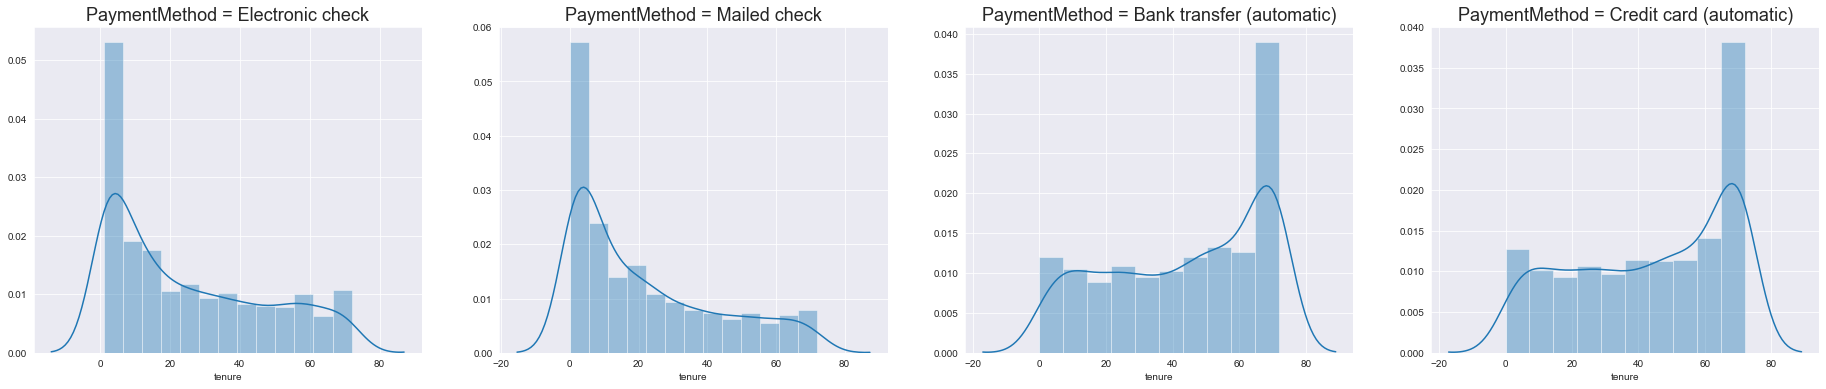

In [19]:
plt.figure(figsize=(32,6))
for num,metode in enumerate(df['PaymentMethod'].unique()):
    plt.subplot(1,len(df['PaymentMethod'].unique()),num+1)
    sns.distplot(df[df['PaymentMethod']==metode]['tenure'])
    plt.title('PaymentMethod = {}'.format(metode), fontsize=18)

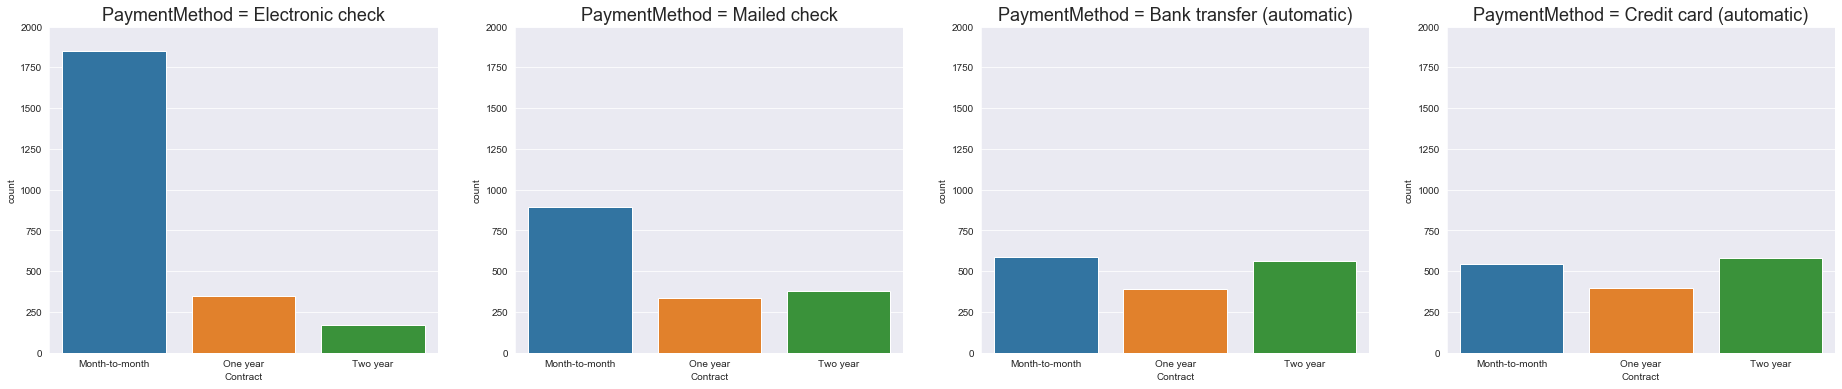

In [20]:
plt.figure(figsize=(32,6))
for num,metode in enumerate(df['PaymentMethod'].unique()):
    plt.subplot(1,len(df['PaymentMethod'].unique()),num+1)
    sns.countplot(df[df['PaymentMethod']==metode]['Contract'],order=df['Contract'].unique())
    plt.ylim(0,2000)
    plt.title('PaymentMethod = {}'.format(metode), fontsize=18)

Range tenure untuk PaymentMethod Electronic check adalah 24.320084566596194 sampai 26.07061310782241
Range tenure untuk PaymentMethod Mailed check adalah 20.797146401985113 sampai 22.825062034739453
Range tenure untuk PaymentMethod Bank transfer (automatic) adalah 42.501295336787564 sampai 44.829015544041454
Range tenure untuk PaymentMethod Credit card (automatic) adalah 41.939553219448094 sampai 44.40341655716163


Text(0.5, 1.0, 'Range tenure with PaymentMethod')

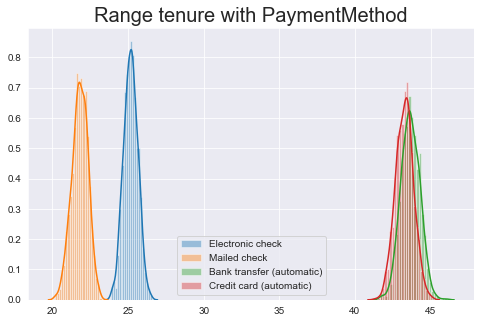

In [21]:
plt.figure(figsize=(8,5))
for i in df['PaymentMethod'].unique():
    sns.distplot(make_bootstrap(1000, df[df['PaymentMethod']==i]['tenure'], 'isi'), label=i)
    print('Range tenure untuk PaymentMethod {} adalah {} sampai {}'.format(i,make_bootstrap(1000, df[df['PaymentMethod']==i]['tenure'], '')[0],make_bootstrap(1000, df[df['PaymentMethod']==i]['tenure'], '')[1]))
plt.legend()
plt.title('Range tenure with PaymentMethod',fontsize=20)

Range TotalCharges untuk PaymentMethod Electronic check adalah 2003.4990486257896 sampai 2180.063298097252
Range TotalCharges untuk PaymentMethod Mailed check adalah 984.5237282878418 sampai 1122.2400744416896
Range TotalCharges untuk PaymentMethod Bank transfer (automatic) adalah 2954.2346502590694 sampai 3193.200161917098
Range TotalCharges untuk PaymentMethod Credit card (automatic) adalah 2944.084034165569 sampai 3190.114421813406


Text(0.5, 1.0, 'Range TotalCharges with PaymentMethod')

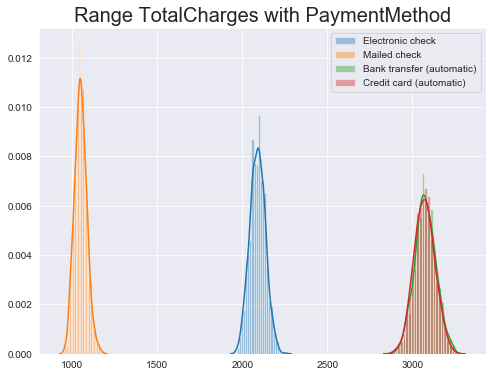

In [22]:
plt.figure(figsize=(8,6))
for i in df['PaymentMethod'].unique():
    print('Range TotalCharges untuk PaymentMethod {} adalah {} sampai {}'.format(i,make_bootstrap(1000, df[df['PaymentMethod']==i]['TotalCharges'], '')[0],make_bootstrap(1000, df[df['PaymentMethod']==i]['TotalCharges'], '')[1]))
    sns.distplot(make_bootstrap(1000,df[df['PaymentMethod']==i]['TotalCharges'],'isi'),label=i)
plt.legend()
plt.title('Range TotalCharges with PaymentMethod',fontsize=20)

Pada counplot partner untuk setiap PaymentMethod, ditunjukkan data PaymentMethod via Mailed Check cenderung tidak memiliki partner. Hal ini mungkin dikarenakan PaymentMethod via Mailed check akan dikirim ke satu pelanggan, dimana jika memiliki partner akan susah untuk membagi pembayaran.


Pada grafik range distplot untuk tenure, dapat dilihat langganan yang memiliki jangka waktu 42 sampai 44 bulan cenderung menggunakan PaymentMethod yang bersifat automatic (credit card dan bank tranfer). Sedangkan langganan yang jangka waktunya 20 sampai 26 nulan cenderung menggunakan PaymentMethod Electronic dan Mailed check.


Hal ini juga berlaku untuk TotalCharges, langganan yang memiliki TotalCharges 2900 sampai 3100 lebih sering menggunakan PaymentMethod yang bersifat automatic (credit card dan bank transfer). Sedangkan, langganan dengan TotalCharges 900 sampai 1100 cenderung melakukan pembayaran dengan metode electronic check. Untuk PaymentMethod mailed check, langganannya memiliki range TotalCharges dari 2000 sampai 2100.

That is enough EDA between feature, now let's focus to the our target (Churn). First, try to visualize the count of the Churn feature

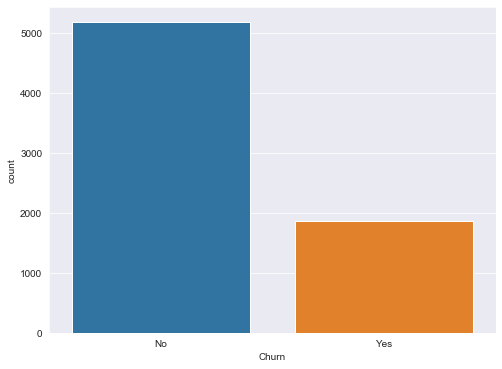

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(df['Churn'])

It seems we have a case of imbalanced dataset for churn prediction. Let's try to visualize the distirbution for every category and numerical columns that we have. Before we proceed, replace the SeniorCitizen feature value with 0 as No and 1 as Yes.

In [24]:
df['SeniorCitizen']=df['SeniorCitizen'].apply(lambda x: 'Yes' if x==1 else 'No')

In [25]:
df_category=df.select_dtypes('object').drop(['customerID'],axis=1)
df_num=pd.concat([df.select_dtypes(exclude='object'),df['Churn']], axis=1)

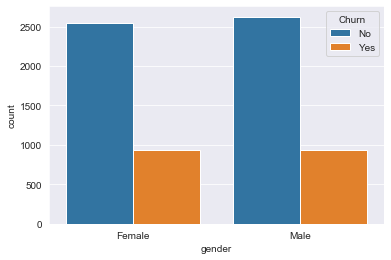

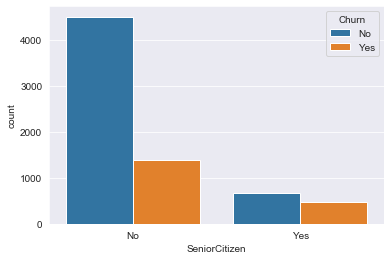

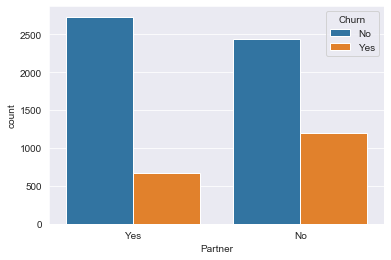

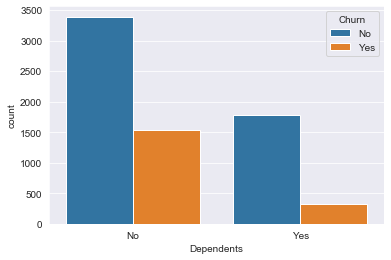

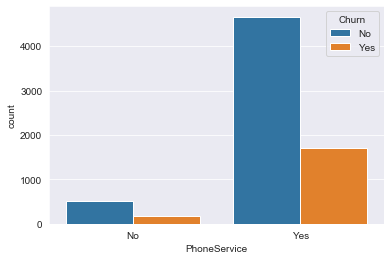

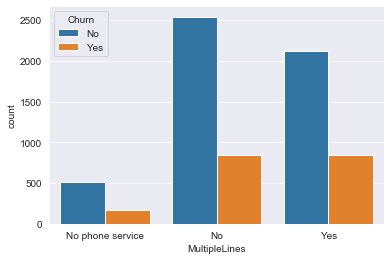

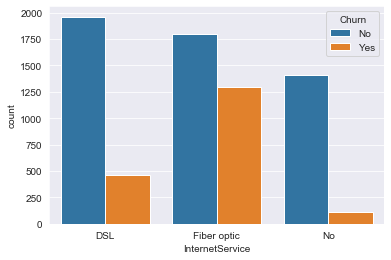

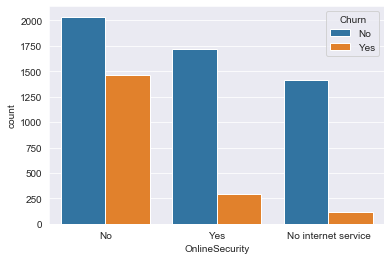

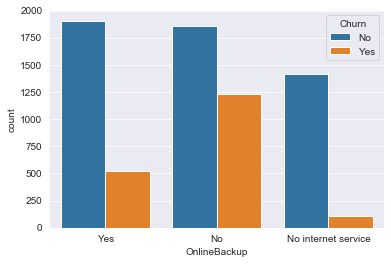

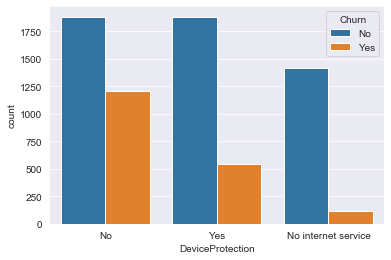

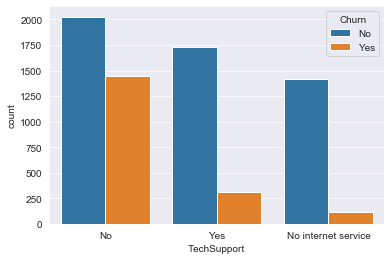

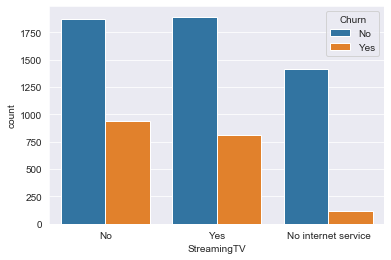

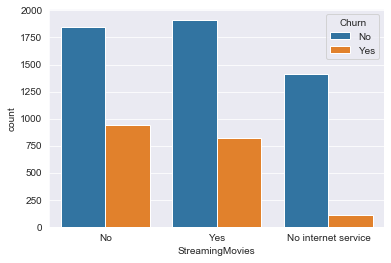

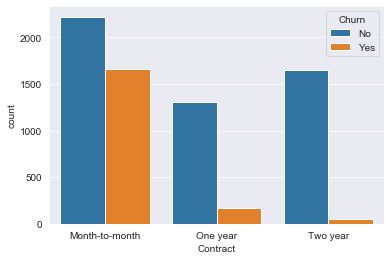

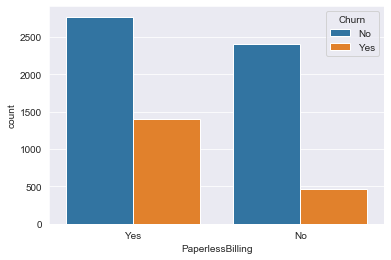

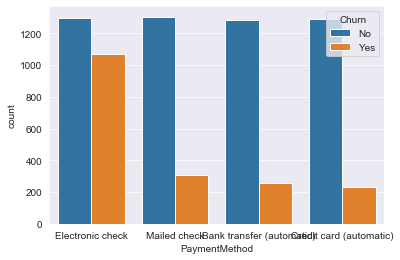

In [26]:
for i in df_category.drop(['Churn'],axis=1).columns:
    sns.countplot(data=df,x=i,hue='Churn')
    plt.show()

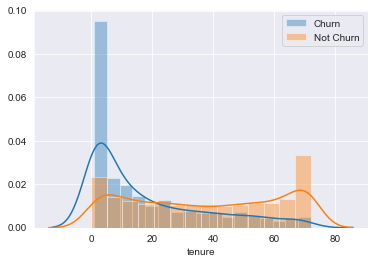

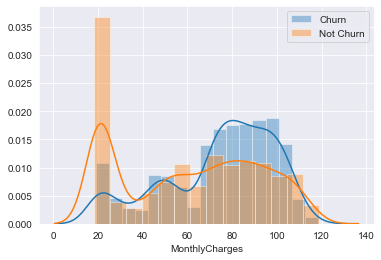

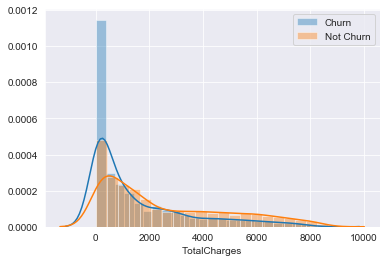

In [27]:
for i in df_num.drop(['Churn'],axis=1).columns:
    sns.distplot(df[df['Churn']=='Yes'][i],label='Churn')
    sns.distplot(df[df['Churn']=='No'][i],label='Not Churn')
    plt.legend()
    plt.show()

Pelanggan yang bukan merupakan SeniorCitizen, lebih cenderung untuk tidak berhenti berlangganan. Dapat dilihat juga langganan yang berupa phone service lebih cenderung berhenti berlangganan. Banyak pelanggan yang memilih pembayaran Electronic check berhenti berlangganan. Langganan yang memiliki contract per bulan lebih cenderung untuk menghentikan langganannya. Berbeda dengan langganan yang memiliki contract jangka waktu lebih lama berupa 1-2 tahun, jumlah langganan yang berhenti lebih sedikit.

Pelanggan yang memiliki jangka waktu tenure yang lama akan cenderung terus berlangganan, sedangkan tenure yang lebih kecil akan cenderung untuk berhenti berlangganan. Kemudian, langganan dengan MonthlyCharges yang lebih mahal cenderung menghentikkan langganannya, sedangkan langganan yang memiliki MonthlyCharges lebih kecil akan terus berlangganan.

As our aim is to use machine learning for prediction, lets prepare our columns to be ready for machine learning activities. First, drop the CustomerID column then change all the category columns into numerical value by using get_dummies (OneHotEncoder) except the target column (Churn). Also, set the drop_first parameter as True.

At the same time, change the Churn feature value with No as 0 and Yes as 1

In [28]:
df.drop(['customerID'],axis=1,inplace=True)
df['Churn']=df['Churn'].apply(lambda x: 0 if x=='No' else 1)
df=pd.get_dummies(data=df, drop_first=True, columns=df_category.drop(['Churn'],axis=1).columns)

In [29]:
data=df.drop(['Churn'],axis=1)
target=df['Churn']
data.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1840.75,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 30 columns):
tenure                                   7043 non-null int64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
gender_Male                              7043 non-null uint8
SeniorCitizen_Yes                        7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
PhoneService_Yes                         7043 non-null uint8
MultipleLines_No phone service           7043 non-null uint8
MultipleLines_Yes                        7043 non-null uint8
InternetService_Fiber optic              7043 non-null uint8
InternetService_No                       7043 non-null uint8
OnlineSecurity_No internet service       7043 non-null uint8
OnlineSecurity_Yes                       7043 non-null uint8
OnlineBackup_No internet service   

## Unsurpervised Modelling

Before we do any of the supervised modelling, let's do some data mining from our data. Remember, as lot of unsupervised model based on distance means that we need to rescale our data to have a same scale. 

In our case, we would use all the data except the target data for data mining. 

First, use the boxplot to check all the data distribution

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

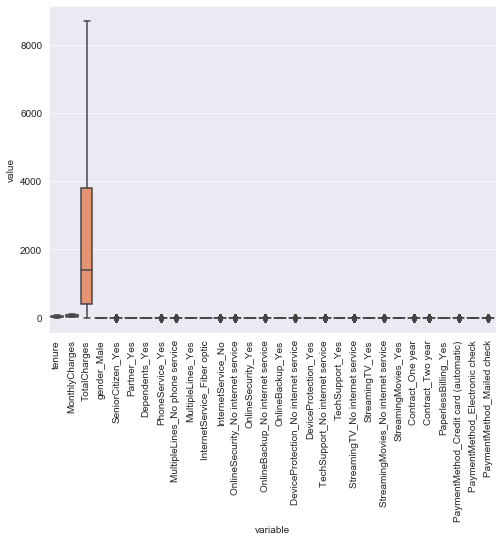

In [31]:
plt.figure(figsize=(8,6))
sns.boxplot(data=pd.melt(data),x='variable',y='value')
plt.xticks(rotation=90)

Just from the boxplot, we could see that the scale is not similar. In this case, lets rescale all the data by using the StandardScaler then check the data one more time to know our data distribution

In [32]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [33]:
scaled_data=scaler.transform(data)
scaled_df=pd.DataFrame(data=scaled_data, columns=data.columns)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text xticklabel objects>)

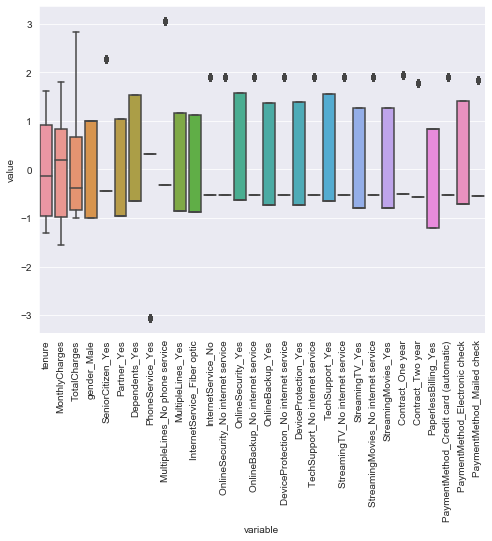

In [34]:
plt.figure(figsize=(8,6))
sns.boxplot(data=pd.melt(scaled_df),x='variable',y='value')
plt.xticks(rotation=90)

We have lot of feature to be put into our unsupervised model, because of that let's use PCA to reduce our feature to 2 feature with random_state = 101. PC1 and PC2. 

In [35]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2, random_state=101)
pca.fit(scaled_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=101,
    svd_solver='auto', tol=0.0, whiten=False)

In [36]:
data_pca=pca.transform(scaled_df)
pc=pd.DataFrame(data=data_pca, columns=['PC1','PC2'])

In [37]:
pc

,PC1,PC2
0,-0.432402,-3.150994
1,-0.204024,-0.794405
2,-0.160382,-2.089736
3,-0.898671,-0.878803
4,-0.613839,-3.175062
...,...,...
7038,-1.895955,1.301241
7039,-3.132402,3.147387
7040,-0.342003,-2.486628
7041,-0.616559,-2.049118


In [38]:
pca.explained_variance_ratio_

array([0.33179753, 0.11983851])

Our 2 PC only explained around 45 variance of the data, but we could just work with this data right now. Let's use the scatter plot to see the distribution of the 2 PC with the Churn feature as the hue

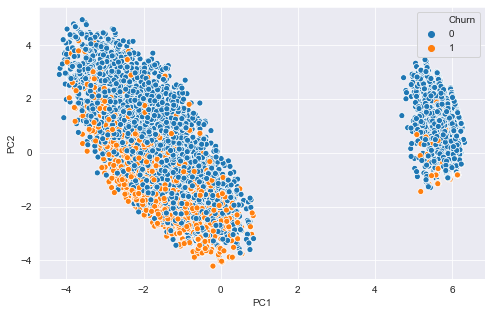

In [39]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=pc, x='PC1', y='PC2', hue=target)

Seems our 2 PC resulting in the 2 different group, it is really interesting as it is not usable for separating our Churn feature but it might end up with another fascinating observation. 

Now, we would use KMeans, DBSCAN, and HDBSCAN to cluster our 2 PC. This time, I already done some analysis and find the best parameter we could use. Try to use the KMeans model with n_cluster = 2, DBSCAN model with eps = 0.4 and min_samples = 2, and HDBSCAN model with min_cluster_size =2 and min_samples = 25

Then create the scatter plot to compare the separation performance of each model. 

In [40]:
from sklearn.cluster import KMeans,DBSCAN
from hdbscan import HDBSCAN

kmeans=KMeans(n_clusters=2)
dbscan=DBSCAN(eps=0.4, min_samples=2)
hdbscan=HDBSCAN(min_cluster_size=2, min_samples=25)

kmeans.fit(pc)
dbscan.fit(pc)
hdbscan.fit(pc)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=2, min_samples=25, p=None,
        prediction_data=False)

Text(0.5, 1.0, 'HDBSCAN')

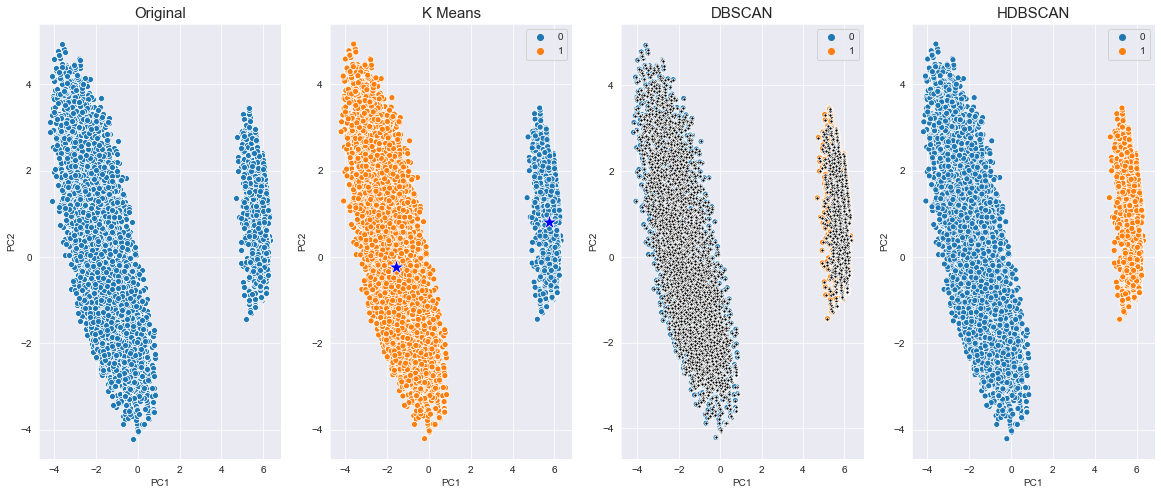

In [41]:
plt.figure(figsize=(20,8))

plt.subplot(1,4,1)
sns.scatterplot(data=pc, x='PC1', y='PC2')
plt.title('Original', fontsize=15)

plt.subplot(1,4,2)
centroid=kmeans.cluster_centers_
sns.scatterplot(data=pc, x='PC1', y='PC2', hue=kmeans.labels_, cmap='rainbow')
sns.scatterplot(centroid[:,0], centroid[:,1], marker='*', color='b', s=250)
plt.title('K Means', fontsize=15)

plt.subplot(1,4,3)
core=dbscan.components_
sns.scatterplot(data=pc, x='PC1', y='PC2', hue=dbscan.labels_, cmap='rainbow')
sns.scatterplot(core[:,0], core[:,1], marker='o', color='black', s=10)
plt.title('DBSCAN', fontsize=15)

plt.subplot(1,4,4)
sns.scatterplot(data=pc, x='PC1', y='PC2', hue=hdbscan.labels_, cmap='rainbow')
plt.title('HDBSCAN', fontsize=15)

Seems all of our our model resulting in 2 different cluster, just like we expected. Now, return the label from the KMeans model back to the original data and use the pair plot to see the relation between the numerical value with the label as the hue (I am personally name it k-label)

In [42]:
data_pairplot=data.copy()
data_pairplot['k_labels']=kmeans.labels_
data_pairplot=pd.concat([data_pairplot,target],axis=1)

RuntimeError: Selected KDE bandwidth is 0. Cannot estimate density.

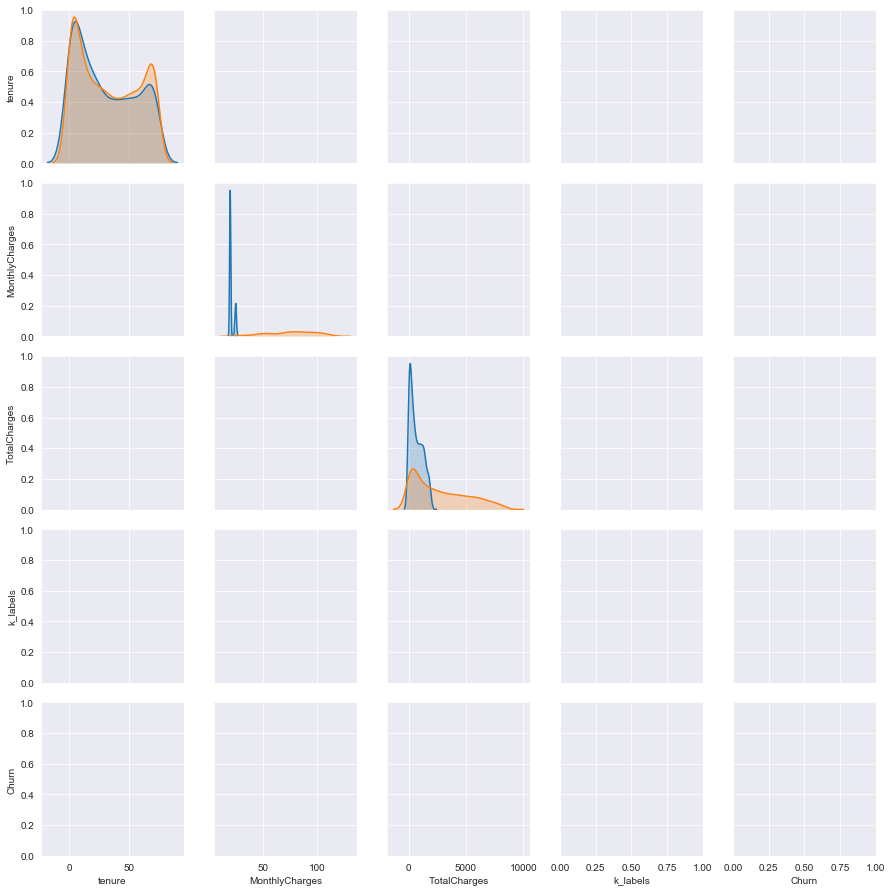

In [43]:
sns.pairplot(data_pairplot.select_dtypes(include=['int64','float','int32']), hue='k_labels')

Berdasarkan pairplot diatas, ditunjukkan KMeans clustering dibagi berdasarkan jumlah MonthlyCharges dan TotalCharges. Pada gambar scatterplot data MonthlyCharges dan TotalCharges, dapat dilihat data dengan labels 1 merupakan langganan yang memiliki MonthlyCharges yang nilainya sekitar dibawah 30 dan TotalCharges yang nilainya sekitar dibawah 2000. Sedangkan untuk labels 0 merupakan data-data selain labels 1. Sehingga dapat disimpulkan:

    1. Label 1 : langganan yang memiliki TotalCharges<2000 dan MonthlyCharges<30
    2. Label 0 : langganan yang memiliki TotalCharges>2000 dan MonthlyCharges>30

### Supervised Modelling

First, done the Train Test Split by using random_state=101 and test size =0.2

In [44]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(data, target, test_size=0.2, random_state=101)

If you remember, we have a case of data imbalance for our Churn feature. We could use SMOTE to try oversampling our data. In this time try use SMOTE to our x_train data but keep it in new variable so we would have 2 different kind of x_train; with and without oversampling.

In [45]:
from imblearn.over_sampling import SMOTE

sm=SMOTE(sampling_strategy='minority')
over_X, over_Y=sm.fit_sample(x_train,y_train)
oversampled_train=pd.concat([pd.DataFrame(over_X),pd.DataFrame(over_Y)],axis=1)

In [46]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 240 to 4959
Data columns (total 30 columns):
tenure                                   5634 non-null int64
MonthlyCharges                           5634 non-null float64
TotalCharges                             5634 non-null float64
gender_Male                              5634 non-null uint8
SeniorCitizen_Yes                        5634 non-null uint8
Partner_Yes                              5634 non-null uint8
Dependents_Yes                           5634 non-null uint8
PhoneService_Yes                         5634 non-null uint8
MultipleLines_No phone service           5634 non-null uint8
MultipleLines_Yes                        5634 non-null uint8
InternetService_Fiber optic              5634 non-null uint8
InternetService_No                       5634 non-null uint8
OnlineSecurity_No internet service       5634 non-null uint8
OnlineSecurity_Yes                       5634 non-null uint8
OnlineBackup_No internet service 

The oversampled X_train data

In [47]:
over_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8296 entries, 0 to 8295
Data columns (total 30 columns):
tenure                                   8296 non-null int64
MonthlyCharges                           8296 non-null float64
TotalCharges                             8296 non-null float64
gender_Male                              8296 non-null uint8
SeniorCitizen_Yes                        8296 non-null uint8
Partner_Yes                              8296 non-null uint8
Dependents_Yes                           8296 non-null uint8
PhoneService_Yes                         8296 non-null uint8
MultipleLines_No phone service           8296 non-null uint8
MultipleLines_Yes                        8296 non-null uint8
InternetService_Fiber optic              8296 non-null uint8
InternetService_No                       8296 non-null uint8
OnlineSecurity_No internet service       8296 non-null uint8
OnlineSecurity_Yes                       8296 non-null uint8
OnlineBackup_No internet service   

Berikut merupakan alasan mengapa saya menggunakan model prediksi berikut :
    
    1. Random Forest
        Saya memilih menggunakan random forest karena model ini tidak mempengaruhi multicolineary,
        Dalam hal ini memang, kita belum tau kolom mana yang memiliki multicolineary. Namun,
        saya ingin membandingkan model yang bergantung dengan multicolineary dengan model yang tidak 
        bergantung.
        
    2. XGBoost Classifier
        Dalam decision tree terdapat 2 cara untuk mengoptimassikan model, yaitu terdapat Bagging yaitu
        random forest dan boosting. Dalam model ini saya ingin membanding kedua metode untuk 
        mengoptimasikan model.
        
    3. Logistic Regression
        Disini, saya menggunakan logistic regression karena merupakan tipe regresi yang bergantung 
        dengan log odd dari suatu probability. Dan alasan saya memilih model regresi, karena saya ingin
        melihat perbedaan model yang bergantung dengan multicol namun dihilangkan kolom multicolnya dan 
        model yang tidak bergantung sama sekali.

In [48]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

rfc=RandomForestClassifier()
boost=XGBClassifier()
logit=LogisticRegression()

### Mengoptimasikan hyperparameter menggunakan randomized search 

In [49]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators=[int(x) for x in np.linspace(start=200,stop=2000,num=10)]
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
max_features=['auto','sqrt']
max_depth.append(None)
min_samples_split=[int(x) for x in np.linspace(start=100, stop=1000, num=100)]
min_samples_leaf=[int(x) for x in np.linspace(1,11,num=10)]
bootstrap=[True,False]
random_grid_rfc={'n_estimators':n_estimators,
            'max_features':max_features,
            'max_depth':max_depth,
            'min_samples_split':min_samples_split,
            'min_samples_leaf':min_samples_leaf,
            'bootstrap':bootstrap}

learning_rate=[0.01,0.02,0.03,0.04,0.05,0.1]
random_grid_boost={'n_estimators':n_estimators,
                'learning_rate=':learning_rate,
                'max_depth':max_depth}

penalty=['l1','l2','elasticnet',None]
dual=[True,False]
max_iter=[int(x) for x in np.linspace(start=100,stop=1000,num=10)]
random_grid_logit={'penalty':penalty,
                  'dual':dual,
                  'max_iter':max_iter}


### Randomized Search CV

In [50]:
rf_random=RandomizedSearchCV(estimator=rfc,param_distributions=random_grid_rfc,n_iter=10,cv=3,n_jobs=-1,scoring='accuracy')

In [51]:
rf_random.fit(x_train,y_train)
rf_random.best_params_

{'n_estimators': 1200,
 'min_samples_split': 100,
 'min_samples_leaf': 11,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [52]:
boost_random=RandomizedSearchCV(estimator=boost,param_distributions=random_grid_boost,n_iter=10,cv=3,n_jobs=-1,scoring='accuracy')

In [53]:
boost_random.fit(x_train,y_train)
boost_random.best_params_

{'n_estimators': 600, 'max_depth': 80, 'learning_rate=': 0.02}

In [54]:
logit_random=RandomizedSearchCV(estimator=logit,param_distributions=random_grid_logit,n_iter=10,cv=3,n_jobs=-1,scoring='accuracy')

In [55]:
logit_random.fit(x_train,y_train)
logit_random.best_params_

{'penalty': 'l2', 'max_iter': 800, 'dual': False}

### Normal Data

In [56]:
from sklearn.metrics import classification_report

rfc=RandomForestClassifier(n_estimators=1600, min_samples_split=100,
                           min_samples_leaf=6, max_features='auto', max_depth=90, bootstrap=False)
rfc.fit(x_train,y_train)
predict_rfc=rfc.predict(x_test)

xgboost=XGBClassifier(n_estimators=800, max_depth=100, learning_rate=0.01)
xgboost.fit(x_train,y_train)
predict_boost=xgboost.predict(x_test)

logit=LogisticRegression(penalty='l2', max_iter=800, dual=False)
logit.fit(x_train,y_train)
predict_logit=logit.predict(x_test)

### Oversampled Data

In [57]:
from sklearn.metrics import classification_report

rfc=RandomForestClassifier(n_estimators=1600, min_samples_split=100,
                           min_samples_leaf=6, max_features='auto', max_depth=90, bootstrap=False)
rfc.fit(over_X,over_Y)
over_predict_rfc=rfc.predict(x_test)

xgboost=XGBClassifier(n_estimators=800, max_depth=100, learning_rate=0.01)
xgboost.fit(over_X,over_Y)
over_predict_boost=xgboost.predict(x_test)

logit=LogisticRegression(penalty='l2', max_iter=800, dual=False)
logit.fit(over_X,over_Y)
over_predict_logit=logit.predict(x_test)

In [58]:
print('\t\tRANDOM FOREST CLASSIFIER NORMAL DATA')
print(classification_report(predict_rfc,y_test))
print('\n\t\tRANDOM FOREST CLASSIFIER OVERSAMPLED DATA')
print(classification_report(over_predict_rfc,y_test))

		RANDOM FOREST CLASSIFIER NORMAL DATA
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1150
           1       0.46      0.68      0.55       259

    accuracy                           0.80      1409
   macro avg       0.69      0.75      0.71      1409
weighted avg       0.84      0.80      0.81      1409


		RANDOM FOREST CLASSIFIER OVERSAMPLED DATA
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       994
           1       0.63      0.58      0.61       415

    accuracy                           0.78      1409
   macro avg       0.73      0.72      0.73      1409
weighted avg       0.77      0.78      0.77      1409



In [59]:
print('\n\t\tXGBOOST CLASSIFIER NORMAL DATA')
print(classification_report(predict_boost,y_test))
print('\n\t\tXGBOOST CLASSIFIER OVERSAMPLED DATA')
print(classification_report(over_predict_boost,y_test))


		XGBOOST CLASSIFIER NORMAL DATA
              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1116
           1       0.45      0.58      0.51       293

    accuracy                           0.76      1409
   macro avg       0.66      0.70      0.67      1409
weighted avg       0.79      0.76      0.77      1409


		XGBOOST CLASSIFIER OVERSAMPLED DATA
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1036
           1       0.54      0.55      0.54       373

    accuracy                           0.76      1409
   macro avg       0.69      0.69      0.69      1409
weighted avg       0.76      0.76      0.76      1409



In [60]:
print('\n\t\tLOGISTIC REGRESSION NORMAL DATA')
print(classification_report(predict_logit,y_test))
print('\n\t\tLOGISTIC REGRESSION OVERSAMPLED DATA')
print(classification_report(over_predict_logit,y_test))


		LOGISTIC REGRESSION NORMAL DATA
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1116
           1       0.50      0.66      0.57       293

    accuracy                           0.79      1409
   macro avg       0.70      0.74      0.72      1409
weighted avg       0.82      0.79      0.80      1409


		LOGISTIC REGRESSION OVERSAMPLED DATA
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       979
           1       0.62      0.56      0.59       430

    accuracy                           0.76      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.76      0.76      0.76      1409



Saya menggunakan metrics berupa accuracy, dikarenakan hasil prediksi berupa categorical (1 as Yes or 0 as No). Oleh karena itu, saya menggunakan metrics accuracy yang ada pada classification report. Hal ini memungkingkan saya untuk melihat ketepatan model prediksi untuk ketiga metode ini.

Hasil di atas menunjukkan model terbaik untuk memprediksi apakah langganan akan berhenti atau tidak adalah Random Forest. Model yang kurang baik dalam melakukan prediksi adalah logistic regression. Hal ini diduga karena adanya multicolineary dalam data tersebut. Namun, secara keseluruhan accuracy prediksi untuk ketiga model ini terbilang cukup baik dengan accuracy rata-rata 77.33%. Namun, presisi dan recall dari prediksi Churn 1 kurang baik, hal ini dikarenakan kurangnya data yang memiliki Churn 1

Ketika model dicoba untuk data normal dan data oversampled, accuracy model menurun sekitar 1-3%. Namun meningkatkan presisi dan recall sekitar 10-20% untuk prediksi Churn 1. Sedangkan presisi dan recall untuk prediksi Churn 0 menurun sekitar 7-10%. Hal ini juga cukup baik diterima. Namun disini saya memilih data yang normal dalam rangka memaksimalkan tingkat accuracy model.

KESIMPULAN:
model dan data terbaik untuk prediksi adalah Random Forest dengan 
{'n_estimators': 1600, 'min_samples_split': 100,
 'min_samples_leaf': 6,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}
dengan data normal

### Feature importance

In [61]:
kolom_penting=[]
kolom_tdk_penting=[]
from scipy.stats import mannwhitneyu
for i in data.select_dtypes(include=['int64','float','int32']).columns:
    if i=='Churn':
        continue
    print(i)
    if mannwhitneyu(df[df['Churn']==0][i],
                   df[df['Churn']==1][i])[1]<0.05:
        print('Reject Ho')
        kolom_penting.append(i)
    else:
        print('Fail to reject Ho')
        kolom_tdk_penting.append(i)
    print('\n')

tenure
Reject Ho


MonthlyCharges
Reject Ho


TotalCharges
Reject Ho




In [62]:
from scipy.stats import chi2_contingency
chi2_check=[]
for i in data.drop(['tenure','MonthlyCharges','TotalCharges'],axis=1).columns:
    if chi2_contingency(pd.crosstab(df['Churn'], df[i]))[1]<0.05:
        chi2_check.append('Reject Ho')
        kolom_penting.append(i)
    else:
        chi2_check.append('Fail to reject Ho')
        kolom_tdk_penting.append(i)
res=pd.DataFrame(data={'Column':data.drop(['tenure','MonthlyCharges','TotalCharges'],axis=1).columns, 'Hypothesis':chi2_check})
res

,Column,Hypothesis
0,gender_Male,Fail to reject Ho
1,SeniorCitizen_Yes,Reject Ho
2,Partner_Yes,Reject Ho
3,Dependents_Yes,Reject Ho
4,PhoneService_Yes,Fail to reject Ho
5,MultipleLines_No phone service,Fail to reject Ho
6,MultipleLines_Yes,Reject Ho
7,InternetService_Fiber optic,Reject Ho
8,InternetService_No,Reject Ho
9,OnlineSecurity_No internet service,Reject Ho


In [63]:
kolom_tdk_penting

['gender_Male', 'PhoneService_Yes', 'MultipleLines_No phone service']

Terdapat 3 kolom yang tidak mempengaruhi hasil prediksi Churn yaitu gender, PhoneService_Yes,dan MultipleLines_No phone service.  Ketiga kolom ini merupakan data yang categorical. Sedangkan untuk semua kolom numerikal terdapat pola data yang berbeda untuk setiap hasil prediksi Churn.

Metode yang saya gunakkan untuk melakukan melihat Feature importance adalah test statistic yaitu mannwhitneyu, test ini saya gunakkan untuk kolom dengan data numerical, sedangkan untuk kolom dengan data categorical saya menggunakan test chi2_contingency.

In [64]:
from sklearn.model_selection import KFold
K=5
kf=KFold(n_splits=K, shuffle=True)

In [65]:
hasilfold=list(kf.split(data,target))
hasilfold

[(array([   0,    1,    3, ..., 7039, 7041, 7042]),
  array([   2,   16,   18, ..., 7035, 7036, 7040])),
 (array([   0,    2,    3, ..., 7040, 7041, 7042]),
  array([   1,    4,    9, ..., 7019, 7032, 7033])),
 (array([   0,    1,    2, ..., 7040, 7041, 7042]),
  array([   5,    6,    7, ..., 7029, 7037, 7038])),
 (array([   0,    1,    2, ..., 7038, 7040, 7041]),
  array([   3,   11,   14, ..., 7028, 7039, 7042])),
 (array([   1,    2,    3, ..., 7039, 7040, 7042]),
  array([   0,   12,   13, ..., 7030, 7034, 7041]))]

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, log_loss, matthews_corrcoef

def calc_train_error(X_train, y_train, model):
    predictions=model.predict(X_train)
    predictProba=model.predict_proba(X_train)
    matt=matthews_corrcoef(y_train, predictions)
    f1=f1_score(y_train, predictions, average='macro')
    report=classification_report(y_train, predictions)
    roc_auc=roc_auc_score(y_train, predictProba[:,1])
    accuracy=accuracy_score(y_train, predictions)
    confMatrix=confusion_matrix(y_train, predictions)
    logloss=log_loss(y_train, predictProba)
    return {
        'report' : report,
        'matthew' : matt,
        'f1' : f1,
        'roc' : roc_auc,
        'accuracy' : accuracy,
        'confusion' : confMatrix,
        'logloss' : logloss
    }
def calc_validation_error(X_test, y_test, model):
    predictions=model.predict(X_test)
    predictProba=model.predict_proba(X_test)
    matt=matthews_corrcoef(y_test, predictions)
    f1=f1_score(y_test, predictions, average='macro')
    report=classification_report(y_test, predictions)
    roc_auc=roc_auc_score(y_test, predictProba[:,1])
    accuracy=accuracy_score(y_test, predictions)
    confMatrix=confusion_matrix(y_test, predictions)
    logloss=log_loss(y_test, predictProba)
    return {
        'report' : report,
        'matthew' : matt,
        'f1' : f1,
        'roc' : roc_auc,
        'accuracy' : accuracy,
        'confusion' : confMatrix,
        'logloss' : logloss
    }
def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error=calc_train_error(X_train, y_train, model)
    validation_error=calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [67]:
train_errors=[]
validation_error=[]
for train_index, val_index in kf.split(data, target):
    #split data
    X_train, X_val=data.iloc[train_index], data.iloc[val_index]
    y_train, y_val=target.iloc[train_index], target.iloc[val_index]
    
    #calculate error
    train_error, val_error=calc_metrics(X_train, y_train, X_val, y_val, rfc)
    
    #append to appropiate list
    train_errors.append(train_error)
    validation_error.append(val_error)

In [68]:
matrix=[]
for i,j in zip(train_errors, validation_error):
    matrix.append([i['accuracy'], j['accuracy'], i['roc'], j['roc'], i['f1'], j['f1'],i['matthew'], j['matthew'],
                   i['logloss'], j['logloss']])
calc_matrix=pd.DataFrame(matrix, columns=['Train Accuracy','Test Accuracy','Train ROC AUC','Test ROC AUC',
                                         'Train F1 Score','Test F1 Score','Train Matthews Corr Coef','Test Matthews Corr Coef',
                                         'Train Logg Loss','Test Log Loss'])
average=[]
for i in calc_matrix.columns:
    average.append(calc_matrix[i].mean())
average_mat=pd.DataFrame(average).T
average_mat.columns=['Train Accuracy','Test Accuracy','Train ROC AUC','Test ROC AUC',
                                         'Train F1 Score','Test F1 Score','Train Matthews Corr Coef','Test Matthews Corr Coef',
                                         'Train Logg Loss','Test Log Loss']
index_label=[]
for i in range(1,len(calc_matrix)+1):
    index_label.append(f'{i} Iteration')
index_label.append('Average')
calculation=pd.concat([calc_matrix, average_mat])
calculation.index=index_label

In [69]:
calculation[['Train Accuracy','Test Accuracy']]

,Train Accuracy,Test Accuracy
1 Iteration,0.821796,0.806955
2 Iteration,0.823039,0.805536
3 Iteration,0.824636,0.797019
4 Iteration,0.821650,0.806818
5 Iteration,0.823780,0.794744
Average,0.822980,0.802215


Dari K-Fold yang dilakukan terhadap model Random Forest, diperoleh accuracy yang stabil untuk data Train perubahan accuracy berupa 0.001%. Sedangkan untuk data Test perubahan accuracynya berupa 0.001%.

# Thank You